# 1. Preparação do notebook

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [ ]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [ ]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Heterocedasticity] Geração de séries temporais.xlsx to [BM Heterocedasticity] Geração de séries temporais.xlsx


,bm_heteroscedasticity_1,bm_heteroscedasticity_2,bm_heteroscedasticity_3,bm_heteroscedasticity_4,bm_heteroscedasticity_5,bm_heteroscedasticity_6,bm_heteroscedasticity_7,bm_heteroscedasticity_8,bm_heteroscedasticity_9,bm_heteroscedasticity_10
0,0.496714,-1.544434,-0.120643,-0.160665,0.269824,-1.153504,-1.239162,1.178275,-2.678408,-0.496440
1,0.358357,-1.051218,-0.470764,-1.545975,0.577584,-302.123778,-0.102988,0.852262,-1.671607,0.696883
2,1.006917,-0.216493,-0.651815,273.603212,-0.181961,0.326851,0.237425,191.234731,-1.406661,0.361209
3,2.533023,-0.818833,-1.367922,-1.852257,0.878579,0.386145,-0.179616,190.550507,-1.583443,-0.212217
4,2.298239,0.350223,-1.728802,-3.088030,0.435163,-1.599820,-1.725778,0.879891,-3.254722,0.069842


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [ ]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [ ]:
# Seleção da série
series = df['bm_heteroscedasticity_1'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [ ]:
X

array([[   0.49671415],
       [   0.35835678],
       [   1.00691733],
       ...,
       [-337.97491953],
       [-344.57753295],
       [-340.72104326]])

In [ ]:
y

array([   0.35835678,    1.00691733,    2.53302298, ..., -344.57753295,
       -340.72104326, -340.71549354])

## 3.2. Normalização

In [ ]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [ ]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [ ]:
# Definição do modelo Conv1D
class Conv1DModel(nn.Module):
    def __init__(self, input_size, num_filters=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=min(kernel_size, input_size), padding=0)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_filters * (input_size - min(kernel_size, input_size) + 1), 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Função para treinar Conv1D com otimização de hiperparâmetros
def train_conv1d(X_train, y_train, input_size):
    best_model = None
    best_loss = float('inf')
    param_grid = {
        'num_filters': [8, 16, 32],
        'kernel_size': [3, 5]
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for num_filters in param_grid['num_filters']:
        for kernel_size in param_grid['kernel_size']:
            kernel_size = min(kernel_size, input_size)  # Ajustar tamanho do kernel
            model = Conv1DModel(input_size, num_filters, kernel_size).to(device)
            criterion = nn.SmoothL1Loss(beta=1.0)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = model

    return best_model

In [ ]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
conv1d_model = train_conv1d(X_train, y_train, input_size=1)

## 3.3. Avaliação do modelo

In [ ]:
# Previsões no conjunto de treino
y_train_pred_scaled = conv1d_model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)).detach().numpy().flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = conv1d_model(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)).detach().numpy().flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [ ]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 51.72%
sMAPE Teste: 156.09%


In [ ]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 67.79
RMSE Teste: 119.76


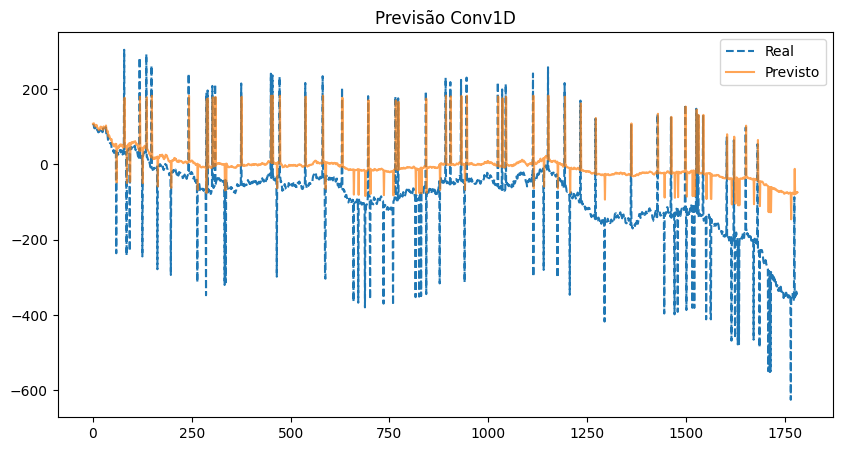

In [ ]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
#plt.title(f'Previsão Conv1D - sMAPE (dados de teste): {smape_test:.2f}%')
plt.title(f'Previsão Conv1D')
plt.show()

# 4. Análise dos erros

In [ ]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
1709,426.963400,151.582703,275.380697
1734,429.669911,158.014221,271.655689
1738,430.843762,153.490509,277.353253
1754,431.518116,154.531708,276.986409
1764,439.173501,163.886276,275.287225
...,...,...,...
1778,-349.127908,-78.022804,-271.105103
1779,-337.974920,-76.458382,-261.516538
1780,-344.577533,-73.652977,-270.924556
1781,-340.721043,-75.313774,-265.407269


In [ ]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,0.358357,25.175644,-24.817287,False
1,1.006917,25.073284,-24.066367,False
2,2.533023,25.553104,-23.020081,False
3,2.298239,26.682129,-24.383890,False
4,2.063314,26.508442,-24.445128,False


In [ ]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 201735.0
Valor-p: 1.0
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [ ]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 367.39702948880586
Valor-p: 1.6624504608529667e-80
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [ ]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.11512924690864791
Valor-p: 5.464532997280017e-19
Existe uma relação significativa entre outliers e a magnitude do erro.
